# get context

- context is obtained from the [https://www.kaggle.com/code/mbanaei/86-2-with-only-270k-articles](https://www.kaggle.com/code/mbanaei/86-2-with-only-270k-articles) notebook

In [1]:

%%writefile get_context.py

RUN_ON_KAGGLE = False
DEBUG = True

import numpy as np
import pandas as pd 
from datasets import load_dataset, load_from_disk
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import LongformerTokenizer, LongformerForMultipleChoice
import transformers
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import unicodedata
import gc
import os

stop_words = ['each', 'you', 'the', 'use', 'used',
                  'where', 'themselves', 'nor', "it's", 'how', "don't", 'just', 'your',
                  'about', 'himself', 'with', "weren't", 'hers', "wouldn't", 'more', 'its', 'were',
                  'his', 'their', 'then', 'been', 'myself', 're', 'not',
                  'ours', 'will', 'needn', 'which', 'here', 'hadn', 'it', 'our', 'there', 'than',
                  'most', "couldn't", 'both', 'some', 'for', 'up', 'couldn', "that'll",
                  "she's", 'over', 'this', 'now', 'until', 'these', 'few', 'haven',
                  'of', 'wouldn', 'into', 'too', 'to', 'very', 'shan', 'before', 'the', 'they',
                  'between', "doesn't", 'are', 'was', 'out', 'we', 'me',
                  'after', 'has', "isn't", 'have', 'such', 'should', 'yourselves', 'or', 'during', 'herself',
                  'doing', 'in', "shouldn't", "won't", 'when', 'do', 'through', 'she',
                  'having', 'him', "haven't", 'against', 'itself', 'that',
                  'did', 'theirs', 'can', 'those',
                  'own', 'so', 'and', 'who', "you've", 'yourself', 'her', 'he', 'only',
                  'what', 'ourselves', 'again', 'had', "you'd", 'is', 'other',
                  'why', 'while', 'from', 'them', 'if', 'above', 'does', 'whom',
                  'yours', 'but', 'being', "wasn't", 'be']


from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata


def SplitList(mylist, chunk_size):
    return [mylist[offs:offs+chunk_size] for offs in range(0, len(mylist), chunk_size)]


def get_relevant_documents(df_valid):
    df_chunk_size=800
    if RUN_ON_KAGGLE:
        cohere_dataset_filtered = load_from_disk("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wiki-stem-cohere")
    else:
        cohere_dataset_filtered = load_from_disk("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wiki-stem-cohere")
    modified_texts = cohere_dataset_filtered.map(lambda example:
                                             {'temp_text':
                                              unicodedata.normalize("NFKD", f"{example['title']} {example['text']}").replace('"',"")},
                                             num_proc=2)["temp_text"]
    
    all_articles_indices = []
    all_articles_values = []
    for idx in tqdm(range(0, df_valid.shape[0], df_chunk_size)):
        df_valid_ = df_valid.iloc[idx: idx+df_chunk_size]
    
        articles_indices, merged_top_scores = retrieval(df_valid_, modified_texts)
        all_articles_indices.append(articles_indices)
        all_articles_values.append(merged_top_scores)
        
    article_indices_array =  np.concatenate(all_articles_indices, axis=0)
    articles_values_array = np.concatenate(all_articles_values, axis=0).reshape(-1)
    
    top_per_query = article_indices_array.shape[1]
    articles_flatten = [(
                         articles_values_array[index],
                         cohere_dataset_filtered[idx.item()]["title"],
                         unicodedata.normalize("NFKD", cohere_dataset_filtered[idx.item()]["text"]),
                        )
                        for index,idx in enumerate(article_indices_array.reshape(-1))]
    retrieved_articles = SplitList(articles_flatten, top_per_query)
    return retrieved_articles



def retrieval(df_valid, modified_texts):
    
    corpus_df_valid = df_valid.apply(lambda row:
                                     f'{row["prompt"]}\n{row["prompt"]}\n{row["prompt"]}\n{row["A"]}\n{row["B"]}\n{row["C"]}\n{row["D"]}\n{row["E"]}',
                                     axis=1).values
    vectorizer1 = TfidfVectorizer(ngram_range=(1,2),
                                 token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
                                 stop_words=stop_words)
    vectorizer1.fit(corpus_df_valid)
    vocab_df_valid = vectorizer1.get_feature_names_out()
    vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                 token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
                                 stop_words=stop_words,
                                 vocabulary=vocab_df_valid)
    vectorizer.fit(modified_texts[:500000])
    corpus_tf_idf = vectorizer.transform(corpus_df_valid)
    
    print(f"length of vectorizer vocab is {len(vectorizer.get_feature_names_out())}")

    chunk_size = 100000
    top_per_chunk = 30
    top_per_query = 30

    all_chunk_top_indices = []
    all_chunk_top_values = []

    for idx in tqdm(range(0, len(modified_texts), chunk_size)):
        wiki_vectors = vectorizer.transform(modified_texts[idx: idx+chunk_size])
        temp_scores = (corpus_tf_idf * wiki_vectors.T).toarray()
        chunk_top_indices = temp_scores.argpartition(-top_per_chunk, axis=1)[:, -top_per_chunk:]
        chunk_top_values = temp_scores[np.arange(temp_scores.shape[0])[:, np.newaxis], chunk_top_indices]

        all_chunk_top_indices.append(chunk_top_indices + idx)
        all_chunk_top_values.append(chunk_top_values)

    top_indices_array = np.concatenate(all_chunk_top_indices, axis=1)
    top_values_array = np.concatenate(all_chunk_top_values, axis=1)
    
    merged_top_scores = np.sort(top_values_array, axis=1)[:,-top_per_query:]
    merged_top_indices = top_values_array.argsort(axis=1)[:,-top_per_query:]
    articles_indices = top_indices_array[np.arange(top_indices_array.shape[0])[:, np.newaxis], merged_top_indices]
    
    return articles_indices, merged_top_scores

if RUN_ON_KAGGLE:
    if DEBUG:
        df = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/train.csv", index_col="id")
    else:
        df = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/test.csv", index_col="id")
else:
    df = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-llm-science-exam/train.csv", index_col="id")
    # df = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/data_dumps/more_questions/more_questions_raw_questions_wiki_sci_3.csv", index_col="id").sample(n=2048).reset_index(drop=True)


retrieved_articles = get_relevant_documents(df)
gc.collect()


contexts = []

for index in tqdm(range(df.shape[0])):
    row = df.iloc[index]
    # question is 'prompt'
    question = row['prompt']
    options = [row['A'], row['B'], row['C'], row['D'], row['E']]
    context = f"{retrieved_articles[index][-4][2]}\n{retrieved_articles[index][-3][2]}\n{retrieved_articles[index][-2][2]}\n{retrieved_articles[index][-1][2]}"
    contexts.append(context)
    
df['context'] = contexts
df.to_parquet("test_with_context.parquet")

Overwriting get_context.py


In [2]:
!python get_context.py

Loading cached processed dataset at /home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wiki-stem-cohere/cache-e94d488c6798573e_*_of_00002.arrow
  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'd', 'doesn', 'don', 'isn', 'll', 's', 'shouldn', 't', 've', 'wasn', 'weren', 'won'] not in stop_words.
  warnings.warn(
length of vectorizer vocab is 11222

100%|██████████████████████████████████████| 200/200 [00:00<00:00, 56435.74it/s]


answer
B    48
C    44
D    38
A    37
E    33
Name: count, dtype: int64


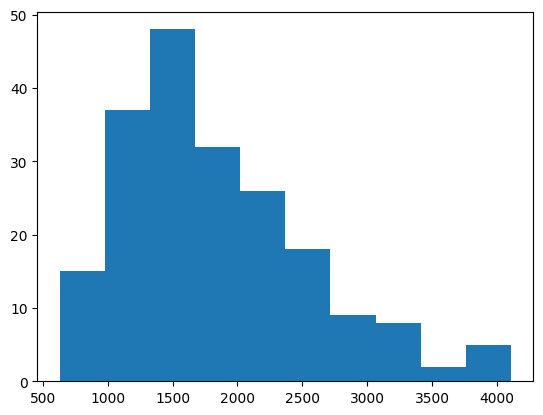

In [3]:
import pandas as pd
df = pd.read_parquet("test_with_context.parquet")
# remove rows for which answer is not either A, B, C, D or E. Make direct comparison
df = df[df['answer'].isin(['A', 'B', 'C', 'D', 'E'])]
print(df['answer'].value_counts())

df['context_len'] = df['context'].apply(lambda x: len(x))
import matplotlib.pyplot as plt

plt.hist(df['context_len'], bins=10);

# llm-science-run-context-2

In [4]:
import os, time
import gc
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import blingfire as bf
from __future__ import annotations

from collections.abc import Iterable

import faiss
from faiss import write_index, read_index

from sentence_transformers import SentenceTransformer

import torch
import ctypes
libc = ctypes.CDLL("libc.so.6")

from dataclasses import dataclass
from typing import Optional, Union

import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from torch.utils.data import DataLoader

from scipy.special import softmax


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.9
CUDA SETUP: Detected CUDA version 121
CUDA SETUP: Loading binary /home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda121.so...


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /home/viktor/miniconda3/envs/torch-env did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('vs/workbench/api/node/extensionHostProcess')}
  warn(msg)
/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)


In [5]:
DEVICE = 0
MAX_LENGTH = 384
BATCH_SIZE = 32

DEBUG = True
# DEBUG = False if len(trn)!=200 else True # If you want to save GPU Quota, check off this comment-out. But cannot get accurate weight on saving notebook
FILTER_LEN = 1 if DEBUG else 9
IND_SEARCH = 1 if DEBUG else 7
NUM_SENTENCES_INCLUDE = 1 if DEBUG else 25
CONTEXT_LEN = 1000 if DEBUG else 2305
VAL_SIZE = 200 if DEBUG else 1500

In [6]:

test_df = pd.read_parquet("test_with_context.parquet")
test_df = test_df[test_df['answer'].isin(['A', 'B', 'C', 'D', 'E'])]
print(test_df['answer'].value_counts())

test_df.index = list(range(len(test_df)))
test_df['id'] = list(range(len(test_df)))
if DEBUG:
    
    def split_prompt(prompt, max_size=400): 
        """
        Splits a given prompt into chunks of size max_size.
        """
        return [prompt[i:i+max_size] for i in range(0, len(prompt), max_size)]

    # Apply the split_prompt function to each row in the "prompt" column
    test_df["context"] = test_df["context"].apply(lambda x: split_prompt(x))

    # Explode the "prompt" column
    test_df = test_df.explode("context", ignore_index=True)
    
    
    test_df["prompt_and_context"] = test_df["context"].apply(lambda x: x[:CONTEXT_LEN]) + " #### " +  test_df["prompt"]
    
else:
    test_df["prompt_and_context"] = test_df["context"].apply(lambda x: x[:CONTEXT_LEN]) + " #### " +  test_df["prompt"]
    
    
if "answer" not in test_df.columns:
    test_df['answer'] = 'A'

answer
B    48
C    44
D    38
A    37
E    33
Name: count, dtype: int64


In [7]:

options = 'ABCDE'
indices = list(range(5))

option_to_index = {option: index for option, index in zip(options, indices)}
index_to_option = {index: option for option, index in zip(options, indices)}

def preprocess(example):
  
    first_sentence = [example['prompt_and_context']] * 5
    second_sentence = []
    for option in options:
        second_sentence.append(example[option])
    
    tokenized_example = tokenizer(first_sentence, second_sentence, truncation='only_first')
    tokenized_example['label'] = option_to_index[example['answer']]
    return tokenized_example

In [8]:
test_df

,prompt,A,B,C,D,E,answer,context,id,prompt_and_context
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,There have been a number of attempts to solve ...,0,There have been a number of attempts to solve ...
1,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,n predicting the rotation curves of low-surfac...,0,n predicting the rotation curves of low-surfac...
2,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,"rom's original proposal, proponents of MOND ha...",0,"rom's original proposal, proponents of MOND ha..."
3,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,vides the best current evidence for the nature...,0,vides the best current evidence for the nature...
4,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,ravitational force law alone.\nThe most seriou...,0,ravitational force law alone.\nThe most seriou...
...,...,...,...,...,...,...,...,...,...,...
1005,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,C,r expressing (apparently for the first time) t...,199,r expressing (apparently for the first time) t...
1006,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,C,"artifacts of the coordinate system he used, an...",199,"artifacts of the coordinate system he used, an..."
1007,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,C,"an Rosen submitted a paper to ""Physical Review...",199,"an Rosen submitted a paper to ""Physical Review..."
1008,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,C,ties of the employed cylindrical coordinates. ...,199,ties of the employed cylindrical coordinates. ...


In [9]:
@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        label_name = "label" if 'label' in features[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]['input_ids'])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors='pt',
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [10]:
# model_dir = "/kaggle/input/how-to-train-open-book-model-part-1/model_v2"
# model_dir = "/kaggle/input/llm-submissions-viktor/work_dirs/deberta-v3-data-wiki_sci-with-wiki-sentence-context-eval-kaggle-all-folds-grad-accum-128-60k/deberta-v3-large-2023-09-05-07-35-55/checkpoint-3281"
model_dir ="/home/viktor/Documents/kaggle/kaggle_llm/work_dirs/160k-viktor-and-deotte-dataset-deotte-preproc-deberta/deberta-v3-large-2023-09-17-10-00-20/checkpoint-14400"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir).cuda()
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


DebertaV2ForMultipleChoice(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_aff

In [11]:
tokenized_test_dataset = Dataset.from_pandas(test_df[['id', 'prompt_and_context', 'A', 'B', 'C', 'D', 'E', 'answer']].drop(columns=['id'])).map(preprocess, remove_columns=['prompt_and_context', 'A', 'B', 'C', 'D', 'E', 'answer'])
# tokenized_test_dataset = tokenized_test_dataset.remove_columns(["__index_level_0__"])
data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=1, shuffle=False, collate_fn=data_collator)

Map:   0%|          | 0/1010 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# viktor

In [12]:
test_predictions_viktor = []


for batch in tqdm(test_dataloader):
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(**batch)
    test_predictions_viktor.append(outputs.logits.cpu().detach())
    
test_predictions_viktor = torch.cat(test_predictions_viktor)

  0%|          | 0/1010 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
test_predictions_viktor = sigmoid(test_predictions_viktor).numpy()


In [14]:
test_predictions_viktor.shape

(1010, 5)

In [15]:
test_df['predictions'] = test_predictions_viktor.tolist()
test_df

,prompt,A,B,C,D,E,answer,context,id,prompt_and_context,predictions
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,There have been a number of attempts to solve ...,0,There have been a number of attempts to solve ...,"[0.09250783920288086, 0.8407570719718933, 0.64..."
1,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,n predicting the rotation curves of low-surfac...,0,n predicting the rotation curves of low-surfac...,"[0.5846375226974487, 0.8440539240837097, 0.816..."
2,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,"rom's original proposal, proponents of MOND ha...",0,"rom's original proposal, proponents of MOND ha...","[0.3250439763069153, 0.8170468807220459, 0.749..."
3,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,vides the best current evidence for the nature...,0,vides the best current evidence for the nature...,"[0.32941102981567383, 0.8600099086761475, 0.58..."
4,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,ravitational force law alone.\nThe most seriou...,0,ravitational force law alone.\nThe most seriou...,"[0.44813472032546997, 0.7416130900382996, 0.84..."
...,...,...,...,...,...,...,...,...,...,...,...
1005,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,C,r expressing (apparently for the first time) t...,199,r expressing (apparently for the first time) t...,"[0.9949422478675842, 0.9864272475242615, 0.996..."
1006,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,C,"artifacts of the coordinate system he used, an...",199,"artifacts of the coordinate system he used, an...","[0.9671119451522827, 0.8518756628036499, 0.998..."
1007,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,C,"an Rosen submitted a paper to ""Physical Review...",199,"an Rosen submitted a paper to ""Physical Review...","[0.988251268863678, 0.9735218286514282, 0.9913..."
1008,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of E

In [16]:
# save test_df as rag_2.parquet
test_df.to_parquet("train_rag_2.parquet")

In [17]:
import pandas as pd
test_df = pd.read_parquet("train_rag_2.parquet")

In [18]:
ids = sorted(list(set(test_df['id'].values)))

avgs = []
maxes  = []
answers = []
diffs_maxes = []

for id in ids:
    df_id = test_df[test_df['id']==id].reset_index(drop=True)
    answer = df_id['answer'].values[0]
    answers.append(answer)
    
    predictions = np.vstack(df_id['predictions'].values)
    
    predictions_avg = np.mean(predictions, axis=0)
    predictions_max = np.max(predictions, axis=0)
    
    predictions_diff = predictions - predictions_avg
    predictions_diff_max = np.max(predictions_diff, axis=0)
    
    
    avgs.append(predictions_avg)
    maxes.append(predictions_max)
    diffs_maxes.append(predictions_diff_max)
    
    diffs_maxes_argmax = np.argmax(diffs_maxes, axis=1)
    
    

In [19]:
df_agg = pd.DataFrame({'id': ids, 'answer': answers, 'avg': avgs, 'max': maxes, 'diff_max': diffs_maxes, 'answers': answers})
df_agg

,id,answer,avg,max,diff_max,answers
0,0,D,"[0.36632032479558674, 0.8219037311417716, 0.77...","[0.5846375226974487, 0.8600099086761475, 0.909...","[0.218317197901862, 0.03810617753437584, 0.131...",D
1,1,A,"[0.9635155200958252, 0.8921937048435211, 0.880...","[0.9724846482276917, 0.9437506794929504, 0.927...","[0.008969128131866455, 0.05155697464942932, 0....",A
2,2,A,"[0.9761407375335693, 0.7615485986073812, 0.904...","[0.983102023601532, 0.8800554871559143, 0.9512...","[0.0069612860679626465, 0.11850688854853308, 0...",A
3,3,C,"[0.9578394293785095, 0.9418489813804627, 0.947...","[0.9696210622787476, 0.9673298597335815, 0.964...","[0.011781632900238037, 0.025480878353118852, 0...",C
4,4,D,"[0.893030027548472, 0.8335470954577128, 0.8401...","[0.8934891819953918, 0.8412802219390869, 0.875...","[0.0004591544469197961, 0.007733126481374142, ...",D
...,...,...,...,...,...,...
195,195,C,"[0.5495106503367424, 0.257383830845356, 0.9865...","[0.6994795799255371, 0.4151361584663391, 0.993...","[0.1499689295887947, 0.15775232762098312, 0.00...",C
196,196,B,"[0.9707178771495819, 0.988326738278071, 0.9866...","[0.9866365790367126, 0.9972278475761414, 0.994...","[0.015918701887130737, 0.008901109298070309, 0...",B
197,197,B,"[0.9921469688415527, 0.9933213442564011, 0.969...","[0.996393620967865, 0.9971568584442139, 0.9812...","[0.004246652126312256, 0.003835514187812805, 0...",B
198,198,D,"[0.7776605188846588, 0.7577532902359962, 0.808...","[0.835703432559967, 0.9376516938209534, 0.9388...","[0.05804291367530823, 0.17989840358495712, 0.1...",D


In [20]:

df_agg['pred_avg'] = df_agg['avg'].apply(lambda x: index_to_option[np.argmax(x)])
df_agg['pred_max'] = df_agg['max'].apply(lambda x: index_to_option[np.argmax(x)])
df_agg['pred_diff_max'] = df_agg['diff_max'].apply(lambda x: index_to_option[np.argmax(x)])

# 2nd to argmax
df_agg['pred_avg_2'] = df_agg['avg'].apply(lambda x: index_to_option[np.argsort(x)[-2]])
df_agg['pred_max_2'] = df_agg['max'].apply(lambda x: index_to_option[np.argsort(x)[-2]])
df_agg['pred_diff_max_2'] = df_agg['diff_max'].apply(lambda x: index_to_option[np.argsort(x)[-2]])

# 3nd to argmax
df_agg['pred_avg_3'] = df_agg['avg'].apply(lambda x: index_to_option[np.argsort(x)[-3]])
df_agg['pred_max_3'] = df_agg['max'].apply(lambda x: index_to_option[np.argsort(x)[-3]])
df_agg['pred_diff_max_3'] = df_agg['diff_max'].apply(lambda x: index_to_option[np.argsort(x)[-3]])

df_agg  

,id,answer,avg,max,diff_max,answers,pred_avg,pred_max,pred_diff_max,pred_avg_2,pred_max_2,pred_diff_max_2,pred_avg_3,pred_max_3,pred_diff_max_3
0,0,D,"[0.36632032479558674, 0.8219037311417716, 0.77...","[0.5846375226974487, 0.8600099086761475, 0.909...","[0.218317197901862, 0.03810617753437584, 0.131...",D,D,D,A,B,E,C,E,C,E
1,1,A,"[0.9635155200958252, 0.8921937048435211, 0.880...","[0.9724846482276917, 0.9437506794929504, 0.927...","[0.008969128131866455, 0.05155697464942932, 0....",A,A,A,D,E,E,B,B,B,C
2,2,A,"[0.9761407375335693, 0.7615485986073812, 0.904...","[0.983102023601532, 0.8800554871559143, 0.9512...","[0.0069612860679626465, 0.11850688854853308, 0...",A,A,D,B,D,A,C,E,E,E
3,3,C,"[0.9578394293785095, 0.9418489813804627, 0.947...","[0.9696210622787476, 0.9673298597335815, 0.964...","[0.011781632900238037, 0.025480878353118852, 0...",C,A,A,E,D,B,B,C,D,C
4,4,D,"[0.893030027548472, 0.8335470954577128, 0.8401...","[0.8934891819953918, 0.8412802219390869, 0.875...","[0.0004591544469197961, 0.007733126481374142, ...",D,D,D,C,A,A,E,C,C,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,C,"[0.5495106503367424, 0.257383830845356, 0.9865...","[0.6994795799255371, 0.4151361584663391, 0.993...","[0.1499689295887947, 0.15775232762098312, 0.00...",C,C,C,B,A,A,A,E,E,E
196,196,B,"[0.9707178771495819, 0.988326738278071, 0.9866...","[0.9866365790367126, 0.9972278475761414, 0.994...","[0.015918701887130737, 0.008901109298070309, 0...",B,B,B,E,C,C,D,A,A,A
197,197,B,"[0.9921469688415527, 0.9933213442564011, 0.969...","[0.996393620967865, 0.9971568584442139, 0.9812...","[0.004246652126312256, 0.003835514187812805, 0...",B,B,B,E,A,D,D,D,A,C
198,198,D,"[0.7776605188846588, 0.7577532902359962, 0.808...","[0.835703432559967, 0.9376516938209534, 0.9388...","[0.05804291367530823, 0.17989840358495712, 0.1...",D,D,D,B,C,C,E,A,B,C


In [21]:
np.average(df_agg['pred_avg'] == df_agg['answer']), np.average(df_agg['pred_max'] == df_agg['answer']), np.average(df_agg['pred_diff_max'] == df_agg['answer'])

(0.86, 0.925, 0.05)

In [22]:
np.average(df_agg['pred_avg_2'] == df_agg['answer']), np.average(df_agg['pred_max_2'] == df_agg['answer']), np.average(df_agg['pred_diff_max_2'] == df_agg['answer'])

(0.08, 0.05, 0.035)

In [23]:
np.average(df_agg['pred_avg_3'] == df_agg['answer']), np.average(df_agg['pred_max_3'] == df_agg['answer']), np.average(df_agg['pred_diff_max_3'] == df_agg['answer'])

(0.035, 0.01, 0.06)

In [24]:
df_agg['diff_max_max_el'] = df_agg['diff_max'].apply(lambda x: np.max(x))
df_agg

,id,answer,avg,max,diff_max,answers,pred_avg,pred_max,pred_diff_max,pred_avg_2,pred_max_2,pred_diff_max_2,pred_avg_3,pred_max_3,pred_diff_max_3,diff_max_max_el
0,0,D,"[0.36632032479558674, 0.8219037311417716, 0.77...","[0.5846375226974487, 0.8600099086761475, 0.909...","[0.218317197901862, 0.03810617753437584, 0.131...",D,D,D,A,B,E,C,E,C,E,0.218317
1,1,A,"[0.9635155200958252, 0.8921937048435211, 0.880...","[0.9724846482276917, 0.9437506794929504, 0.927...","[0.008969128131866455, 0.05155697464942932, 0....",A,A,A,D,E,E,B,B,B,C,0.085512
2,2,A,"[0.9761407375335693, 0.7615485986073812, 0.904...","[0.983102023601532, 0.8800554871559143, 0.9512...","[0.0069612860679626465, 0.11850688854853308, 0...",A,A,D,B,D,A,C,E,E,E,0.118507
3,3,C,"[0.9578394293785095, 0.9418489813804627, 0.947...","[0.9696210622787476, 0.9673298597335815, 0.964...","[0.011781632900238037, 0.025480878353118852, 0...",C,A,A,E,D,B,B,C,D,C,0.035758
4,4,D,"[0.893030027548472, 0.8335470954577128, 0.8401...","[0.8934891819953918, 0.8412802219390869, 0.875...","[0.0004591544469197961, 0.007733126481374142, ...",D,D,D,C,A,A,E,C,C,D,0.035204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,C,"[0.5495106503367424, 0.257383830845356, 0.9865...","[0.6994795799255371, 0.4151361584663391, 0.993...","[0.1499689295887947, 0.15775232762098312, 0.00...",C,C,C,B,A,A,A,E,E,E,0.157752
196,196,B,"[0.9707178771495819, 0.988326738278071, 0.9866...","[0.9866365790367126, 0.9972278475761414, 0.994...","[0.015918701887130737, 0.008901109298070309, 0...",B,B,B,E,C,C,D,A,A,A,0.145047
197,197,B,"[0.9921469688415527, 0.9933213442564011, 0.969...","[0.996393620967865, 0.9971568584442139, 0.9812...","[0.004246652126312256, 0.003835514187812805, 0...",B,B,B,E,A,D,D,D,A,C,0.014870
198,198,D,"[0.7776605188846588, 0.7577532902359962, 0.808...","[0.835703432559967, 0.9376516938209534, 0.9388...","[0.05804291367530823, 0.17989840358495712, 0.1...",D,D,D,B,C,C,E,A,B,C,0.179898


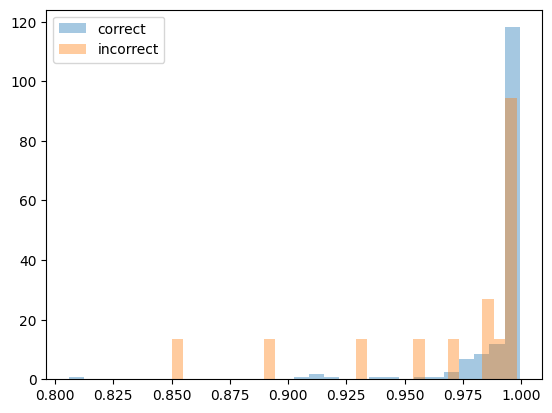

In [25]:
df_agg['max_max_el'] = df_agg['max'].apply(lambda x: np.max(x))

# plt.hist(df_agg['max_max_el'], bins=10, density=True, alpha=0.4, label="correct");

plt.hist(df_agg[df_agg['pred_max']==df_agg['answer']]['max_max_el'], bins=30, density=True, alpha=0.4, label="correct");
plt.hist(df_agg[df_agg['pred_max']!=df_agg['answer']]['max_max_el'], bins=30, density=True, alpha=0.4, label="incorrect");

plt.legend();

In [26]:
df_2 = df_agg[df_agg['max_max_el'] > 0.9]
np.average(df_2['pred_max']==df_2['answer'])

0.934010152284264

In [27]:
df_2 = df_agg[df_agg['max_max_el'] < 0.9]
np.average(df_2['pred_avg_2']==df_2['answer'])

0.0

In [28]:
# create "combined_prediction" as follows: where df_agg['max_max_el'] > 0.9, take pred_max, otherwise take pred_avg_2
df_agg['combined_prediction'] = df_agg.apply(lambda row: row['pred_max'] if row['max_max_el'] > 0.9 else row['pred_avg_2'], axis=1)

np.average(df_agg['combined_prediction']==df_agg['answer'])

0.92

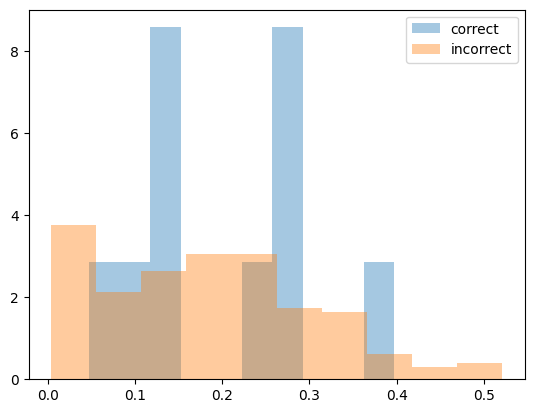

In [29]:
plt.hist(df_agg[(df_agg['pred_diff_max']==df_agg['answer'])]['diff_max_max_el'], bins=10, density=True, alpha=0.4, label="correct");
plt.hist(df_agg[(df_agg['pred_diff_max']!=df_agg['answer'])]['diff_max_max_el'], bins=10, density=True, alpha=0.4, label="incorrect");
plt.legend();

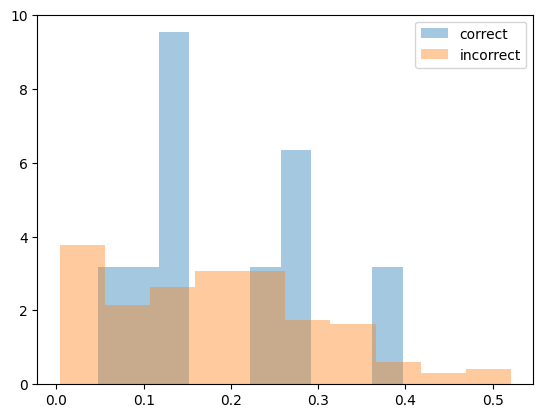

In [30]:
plt.hist(df_agg[(df_agg['pred_diff_max']==df_agg['answer']) & (df_agg['pred_max']==df_agg['answer'])]['diff_max_max_el'], bins=10, density=True, alpha=0.4, label="correct");
plt.hist(df_agg[(df_agg['pred_diff_max']!=df_agg['answer']) & (df_agg['pred_diff_max']!=df_agg['answer'])]['diff_max_max_el'], bins=10, density=True, alpha=0.4, label="incorrect");
plt.legend();

In [31]:
df_agg

,id,answer,avg,max,diff_max,answers,pred_avg,pred_max,pred_diff_max,pred_avg_2,pred_max_2,pred_diff_max_2,pred_avg_3,pred_max_3,pred_diff_max_3,diff_max_max_el,max_max_el,combined_prediction
0,0,D,"[0.36632032479558674, 0.8219037311417716, 0.77...","[0.5846375226974487, 0.8600099086761475, 0.909...","[0.218317197901862, 0.03810617753437584, 0.131...",D,D,D,A,B,E,C,E,C,E,0.218317,0.990507,D
1,1,A,"[0.9635155200958252, 0.8921937048435211, 0.880...","[0.9724846482276917, 0.9437506794929504, 0.927...","[0.008969128131866455, 0.05155697464942932, 0....",A,A,A,D,E,E,B,B,B,C,0.085512,0.972485,A
2,2,A,"[0.9761407375335693, 0.7615485986073812, 0.904...","[0.983102023601532, 0.8800554871559143, 0.9512...","[0.0069612860679626465, 0.11850688854853308, 0...",A,A,D,B,D,A,C,E,E,E,0.118507,0.988126,D
3,3,C,"[0.9578394293785095, 0.9418489813804627, 0.947...","[0.9696210622787476, 0.9673298597335815, 0.964...","[0.011781632900238037, 0.025480878353118852, 0...",C,A,A,E,D,B,B,C,D,C,0.035758,0.969621,A
4,4,D,"[0.893030027548472, 0.8335470954577128, 0.8401...","[0.8934891819953918, 0.8412802219390869, 0.875...","[0.0004591544469197961, 0.007733126481374142, ...",D,D,D,C,A,A,E,C,C,D,0.035204,0.918054,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,C,"[0.5495106503367424, 0.257383830845356, 0.9865...","[0.6994795799255371, 0.4151361584663391, 0.993...","[0.1499689295887947, 0.15775232762098312, 0.00...",C,C,C,B,A,A,A,E,E,E,0.157752,0.993598,C
196,196,B,"[0.9707178771495819, 0.988326738278071, 0.9866...","[0.9866365790367126, 0.9972278475761414, 0.994...","[0.015918701887130737, 0.008901109298070309, 0...",B,B,B,E,C,C,D,A,A,A,0.145047,0.997228,B
197,197,B,"[0.9921469688415527, 0.9933213442564011, 0.969...","[0.996393620967865, 0.9971568584442139, 0.9812...","[0.004246652126312256, 0.003835514187812805, 0...",B,B,B,E,A,D,D,D,A,C,0.014870,0.997157,B
198,198,D,"[0.7776605188846588, 0.7577532902359962, 0.808...","[0.835703432559967, 0.9376516938209534, 0.9388...","[0.05804291367530823, 0.17989840358495712, 0.1...",D,D,D,B,C,C,E,A,B,C,0.179898,0.956320,D


In [32]:
df_xgboost = df_agg[['answer', 'avg', 'max', 'diff_max']]
# avg, max and diff_max are arrays. Create avg_0, avg_1, ..., diff_max_0, diff_max_1, ...
for i in range(5):
    df_xgboost[f'avg_{i}'] = df_xgboost['avg'].apply(lambda x: x[i])
    df_xgboost[f'max_{i}'] = df_xgboost['max'].apply(lambda x: x[i])
    df_xgboost[f'diff_max_{i}'] = df_xgboost['diff_max'].apply(lambda x: x[i])
    
df_xgboost = df_xgboost.drop(columns=['avg', 'max', 'diff_max'])

# convert answer to 0, 1, 2, 3, 4
df_xgboost['answer'] = df_xgboost['answer'].apply(lambda x: option_to_index[x])

df_xgboost

/tmp/ipykernel_2987965/1884921065.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost[f'avg_{i}'] = df_xgboost['avg'].apply(lambda x: x[i])
/tmp/ipykernel_2987965/1884921065.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost[f'max_{i}'] = df_xgboost['max'].apply(lambda x: x[i])
/tmp/ipykernel_2987965/1884921065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,answer,avg_0,max_0,diff_max_0,avg_1,max_1,diff_max_1,avg_2,max_2,diff_max_2,avg_3,max_3,diff_max_3,avg_4,max_4,diff_max_4
0,3,0.366320,0.584638,0.218317,0.821904,0.860010,0.038106,0.777894,0.909080,0.131186,0.982649,0.990507,0.007858,0.812478,0.933549,0.121071
1,0,0.963516,0.972485,0.008969,0.892194,0.943751,0.051557,0.880171,0.927696,0.047525,0.825989,0.911502,0.085512,0.931132,0.951647,0.020515
2,0,0.976141,0.983102,0.006961,0.761549,0.880055,0.118507,0.904230,0.951240,0.047010,0.966260,0.988126,0.021866,0.930902,0.972149,0.041247
3,2,0.957839,0.969621,0.011782,0.941849,0.967330,0.025481,0.947808,0.964271,0.016463,0.951524,0.964710,0.013186,0.911235,0.946994,0.035758
4,3,0.893030,0.893489,0.000459,0.833547,0.841280,0.007733,0.840133,0.875337,0.035204,0.905346,0.918054,0.012709,0.644154,0.671055,0.026901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2,0.549511,0.699480,0.149969,0.257384,0.415136,0.157752,0.986552,0.993598,0.007046,0.237923,0.330299,0.092376,0.392266,0.505310,0.113044
196,1,0.970718,0.986637,0.015919,0.988327,0.997228,0.008901,0.986613,0.994565,0.007952,0.867780,0.944320,0.076540,0.553370,0.698417,0.145047
197,1,0.992147,0.996394,0.004247,0.993321,0.997157,0.003836,0.969176,0.981238,0.012062,0.983010,0.997027,0.014016,0.965946,0.980816,0.014870
198,3,0.777661,0.835703,0.058043,0.757753,0.937652,0.179898,0.808531,0.938862,0.130331,0.946293,0.956320,0.010028,0.247790,0.412025,0.164235


In [33]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X = df_xgboost.drop(columns="answer")
y = df_xgboost["answer"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the datasets into DMatrix instances, which is the data structure XGBoost uses
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for the XGBoost model
param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'multi:softprob',  # for multiclass classification problems
    'num_class': 5  # you mentioned 5 possible values for the answer column
}
num_round =20

# Train the model
bst = xgb.train(param, dtrain, num_round)

# Make predictions
preds_prob = bst.predict(dtest)
preds = preds_prob.argmax(axis=1)

# Evaluate the model
acc = accuracy_score(y_test, preds)
print(f"Accuracy: {acc}")

Accuracy: 0.675
